In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ORIE 5355 - ADS Competition Part 2

For a given set of two prices (1 for each item) and customer information, predict the probability $d_k$ that the customer will buy each item $k$ (or buy nothing). We suggest doing so using a multi-class machine learning model that takes in as covariates:
- Prices ($p_1$, $p_2$)
- The demographic covariates available for every user

Then, you can use the purchase decisions provided in the training data as the true training labels.  Here is an overview of the sklearn multi-class classification algorithms: [1.12. Multiclass and multioutput algorithms — scikit-learn 1.0.1 documentation](https://scikit-learn.org/stable/modules/multiclass.html)

And then to extract the class probabilities, use: predict_proba, as in HW3.

**Warning**: some of the multiclass “classification” algorithms only output probabilities that are either 0 or 1 for each class, even if you use predict_proba. I would recommend not using those algorithms.


## EDA

The training data is composed of 30000 customers, inside `train_pricing_decisions`.

For every training customer, you have:
1. a price they were offered for each item
2. their decision for what item they purchased. `-1` means they purchased neither item, `0` means they purchased item 0, `1` means they purchased item 1. 
3. three user covariates for each user to aid in personalized pricing. 

In [2]:
train_pricing_decisions = pd.read_csv('train_prices_decisions.csv')
test_user_info = pd.read_csv('test_user_info.csv')

In [3]:
train_pricing_decisions.head()

,user_index,Covariate1,Covariate2,Covariate3,price_item_0,price_item_1,item_bought
0,0,0.783155,2.378872,8.342151,72.785084,37.007394,1
1,1,4.127142,4.024276,12.501464,51.414629,54.021070,-1
2,2,2.483091,8.986873,7.125810,31.885499,37.683472,0
3,3,1.534569,6.114015,6.885258,44.781299,61.870340,-1
4,4,5.599879,6.106288,7.010118,37.955789,63.114027,0


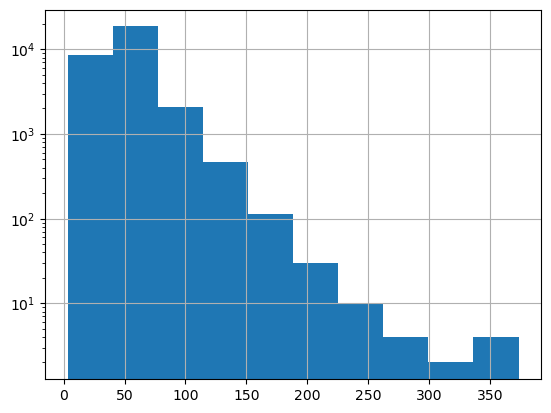

In [4]:
train_pricing_decisions.price_item_0.hist()
plt.yscale('log')

The following plot shows the "1-dimensional" choice for item 0: how the percentage of people who bought item 0 changes with the item 0 price.

<Axes: xlabel='price_item_0'>

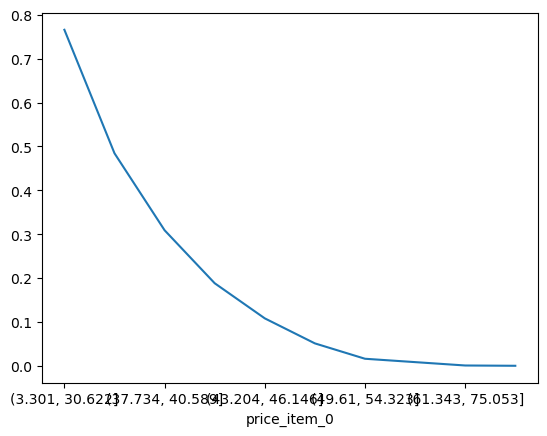

In [5]:
train_pricing_decisions.groupby(pd.qcut(train_pricing_decisions.price_item_0, 10))['item_bought'].agg(lambda x: np.mean([y==0 for y in x])).plot(kind='line')

Of course, the price for item 0 also affects the percentage of people who bought item 1:

<Axes: xlabel='price_item_0'>

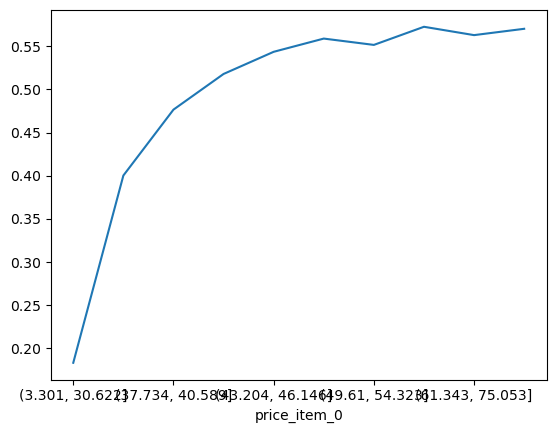

In [6]:
train_pricing_decisions.groupby(pd.qcut(train_pricing_decisions.price_item_0, 10))['item_bought'].agg(lambda x: np.mean([y==1 for y in x])).plot(kind='line')

The test data just has user covariates. Your job is to calculate prices for each item so as to maximize expected revenue from that customer, as you did in Homework 3 (but now with 2 items instead of just 1)

In [7]:
test_user_info.head()

,user_index,Covariate1,Covariate2,Covariate3
0,30000,4.058168,9.823123,6.086879
1,30001,6.423253,0.859018,8.990928
2,30002,1.793184,0.704047,5.865989
3,30003,3.040144,3.961137,13.536446
4,30004,0.161440,1.738395,5.801892


You will be asked to submit a CSV with your calculated optimal prices for each test customer.  The CSV should have four columns: (1) `user_index`, (2) `price_item_0`, (3) `price_item_1`, and (4) `expected_revenue`. The file should be named `part2_static_prices_submission.csv`

In [8]:
test_user_info.describe()

,user_index,Covariate1,Covariate2,Covariate3
count,30000.000000,30000.000000,30000.000000,30000.000000
mean,44999.500000,3.215109,3.217242,9.888635
std,8660.398374,2.434200,2.433359,11.368167
min,30000.000000,0.000266,0.000138,-7.545072
25%,37499.750000,1.283880,1.278591,5.548066
50%,44999.500000,2.705615,2.719015,7.245864
75%,52499.250000,4.644935,4.662646,10.266898
max,59999.000000,16.827321,16.360622,305.277810


## Demand Estimation

In [9]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

### Data Engineering

In [10]:
X = train_pricing_decisions[['Covariate1', 'Covariate2', 'Covariate3', 'price_item_0', 'price_item_1']]
# To avoid: ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]
y = train_pricing_decisions.item_bought.replace({-1: 2})

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Model Selection

In [12]:
def model_quicktest(estimator):

    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('clf', estimator)
    ])

    results = cross_validate(estimator=pipeline, X=X_train, y=y_train,
                             scoring=['accuracy', 'f1_micro', 'roc_auc_ovr', 'roc_auc_ovo', 'neg_log_loss'],
                             cv=5, n_jobs=-1)
    
    print(f"Avg Accuracy: {results['test_accuracy'].mean()}")
    print(f"Avg AUC of ROC Curve (OVR): {results['test_roc_auc_ovr'].mean()}")
    print(f"Avg AUC of ROC Curve (OVO): {results['test_roc_auc_ovo'].mean()}")
    print(f"Avg F1 score: {results['test_f1_micro'].mean()}")
    print(f"Avg Log Loss: {-results['test_neg_log_loss'].mean()}")

In [13]:
model_quicktest(LogisticRegressionCV(max_iter=10000, multi_class='multinomial'))

Avg Accuracy: 0.8548333333333333
Avg AUC of ROC Curve (OVR): 0.9616859332499704
Avg AUC of ROC Curve (OVO): 0.9597562756738455
Avg F1 score: 0.8548333333333332
Avg Log Loss: 0.3697885441237077


In [14]:
model_quicktest(GaussianNB())

/Users/kimsha/anaconda3/envs/ads/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/kimsha/anaconda3/envs/ads/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/kimsha/anaconda3/envs/ads/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Avg Accuracy: 0.745125
Avg AUC of ROC Curve (OVR): 0.9034359904535167
Avg AUC of ROC Curve (OVO): 0.8996509381011488
Avg F1 score: 0.745125
Avg Log Loss: 0.6847795300486538


/Users/kimsha/anaconda3/envs/ads/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/kimsha/anaconda3/envs/ads/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [15]:
model_quicktest(LinearDiscriminantAnalysis())

Avg Accuracy: 0.7862916666666667
Avg AUC of ROC Curve (OVR): 0.9433344355799165
Avg AUC of ROC Curve (OVO): 0.9350336510167722
Avg F1 score: 0.7862916666666667
Avg Log Loss: 0.5129447841771098


In [16]:
model_quicktest(KNeighborsClassifier())

Avg Accuracy: 0.907125
Avg AUC of ROC Curve (OVR): 0.9789906606759782
Avg AUC of ROC Curve (OVO): 0.9775990272219612
Avg F1 score: 0.907125
Avg Log Loss: 0.5152697684558698


In [17]:
model_quicktest(DecisionTreeClassifier())

Avg Accuracy: 0.9110416666666665
Avg AUC of ROC Curve (OVR): 0.9275770961353282
Avg AUC of ROC Curve (OVO): 0.9267031255235757
Avg F1 score: 0.9110416666666667
Avg Log Loss: 3.206383332740214


In [18]:
model_quicktest(RandomForestClassifier())

Avg Accuracy: 0.9497916666666667
Avg AUC of ROC Curve (OVR): 0.9955749684942304
Avg AUC of ROC Curve (OVO): 0.9953577386258494
Avg F1 score: 0.9497916666666667
Avg Log Loss: 0.14949014511659434


In [19]:
model_quicktest(xgb.XGBClassifier())

Avg Accuracy: 0.9616666666666667
Avg AUC of ROC Curve (OVR): 0.997315811223405
Avg AUC of ROC Curve (OVO): 0.9971489539959031
Avg F1 score: 0.9616666666666667
Avg Log Loss: 0.09217936856323723


### Hyperparameter Tuning

Reference:
- https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning#2.-XGBoost-hyperparameters-
- https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [20]:
from hyperopt import tpe, hp, fmin, Trials, STATUS_OK

In [21]:
# For reference
default_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.3,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'colsample_bytree': 1,
    'min_child_weight': 1
}

# Search space
params = {
    # 'model__objective': hp.choice('objective', ['reg:squarederror', 'multi:softmax']),
    # 'model__booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'model__n_estimators' : hp.quniform('n_estimators', 118, 128, 1),
    'model__learning_rate' : hp.quniform('learning_rate', 0.3, 0.35, 0.001),
    'model__max_depth' : hp.quniform('max_depth', 4, 7, 1),
    # 'model__gamma': hp.uniform('gamma', 0, 3),
    # 'model__reg_alpha' : hp.quniform('reg_alpha', 0, 10, 1),
    'model__reg_lambda' : hp.uniform('reg_lambda', 0.9, 1.1),
    'model__subsample': hp.uniform('subsample', 0.9, 1),
    # 'model__colsample_bytree' : hp.uniform('colsample_bytree', 0.9, 1),
    'model__min_child_weight' : hp.quniform('min_child_weight', 0, 5, 1),
}

In [22]:
# Defining Objective function whose loss we have to minimize
def objective(params):
    
    # Initialize model pipeline
    pipeline = Pipeline(steps=[
        # ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(objective='multi:softprob', booster='dart'))
    ])
    # Model parameters will be set here
    params['model__n_estimators'] = int(params['model__n_estimators'])
    params['model__max_depth'] = int(params['model__max_depth'])
    pipeline.set_params(**params)
    
    # Cross Validation Score. Note the transformer.fit_transform for X_train. 
    results = cross_validate(estimator=pipeline, X=X_train, y=y_train,
                             scoring=['accuracy', 'f1_micro', 'roc_auc_ovr', 'roc_auc_ovo', 'neg_log_loss'],
                             cv=5, n_jobs=-1)
          
    # Since we have to minimize the score, we return 1- score.
    return {'loss': -results['test_neg_log_loss'].mean(), 'status': STATUS_OK}

In [23]:
# Hyperopts Trials() records all the model and run artifacts.
trials = Trials()

# Fmin will call the objective funbction with selective param set. 
# The choice of algorithm will narrow the searchspace.
argmin = fmin(fn=objective,
              space=params,
              algo=tpe.suggest,
              max_evals=250,
              trials=trials)

100%|██████████████████████| 250/250 [1:12:10<00:00, 17.32s/trial, best loss: 0.08583738497851315]


In [24]:
argmin['n_estimators'] = int(argmin['n_estimators'])
argmin['max_depth'] = int(argmin['max_depth'])
argmin

{'learning_rate': 0.35000000000000003,
 'max_depth': 5,
 'min_child_weight': 5.0,
 'n_estimators': 125,
 'reg_lambda': 0.9880278472714998,
 'subsample': 0.9048427947263714}

### Training

In [25]:
clf = xgb.XGBClassifier(objective='multi:softprob', booster='dart', **argmin)
# clf = xgb.XGBClassifier(**default_params)

clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.35000000000000003,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5.0, missing=nan, monotone_constraints=None,
              n_estimators=125, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### Evaluation

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss

#### Train

In [52]:
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

In [53]:
print(classification_report(y_train, y_pred))
print(log_loss(y_train, y_pred_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4640
           1       1.00      1.00      1.00     11853
           2       1.00      1.00      1.00      7507

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000

0.026764715253030657


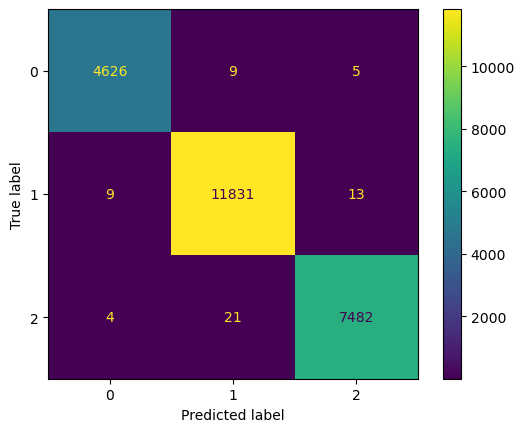

In [54]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot()

#### Test

In [55]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [56]:
print(classification_report(y_test, y_pred))
print(log_loss(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1160
           1       0.97      0.98      0.97      2963
           2       0.96      0.96      0.96      1877

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

0.08498152484182354


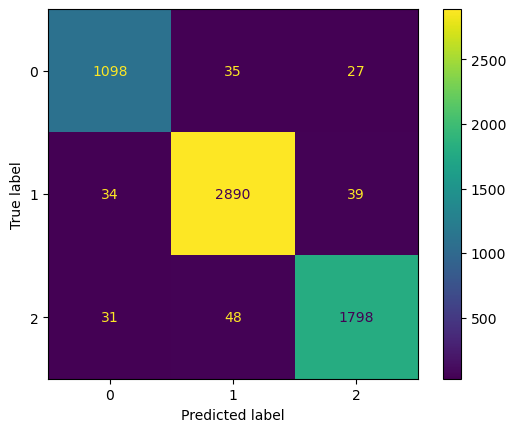

In [57]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

### Calibration

Let's check if we need to calibrate our probabilities:

Reference: https://scikit-learn.org/stable/modules/calibration.html

In [58]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

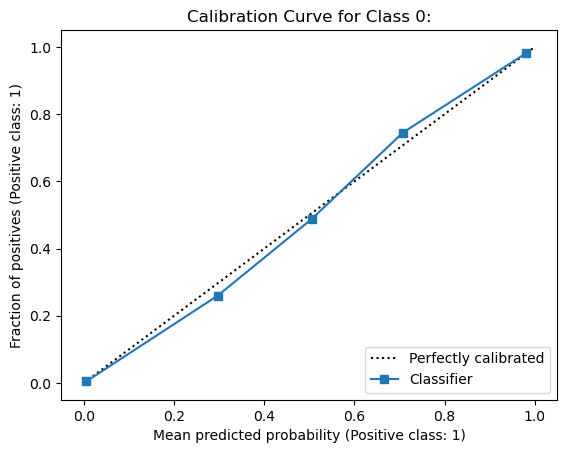

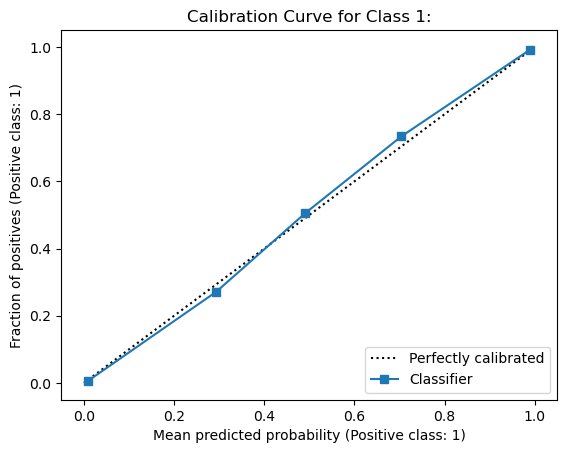

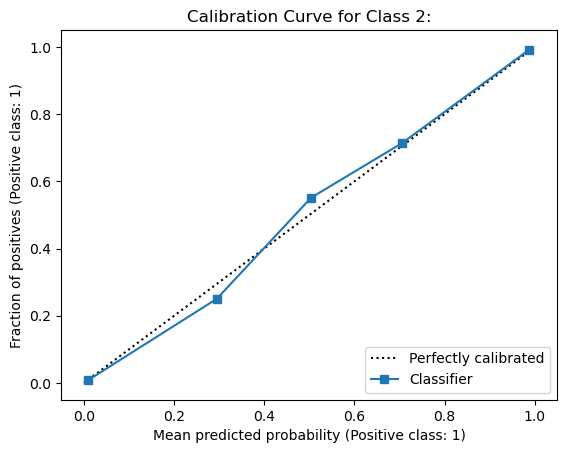

In [59]:
for i in range(3):
    CalibrationDisplay.from_predictions(y_test == i, y_pred_proba[:, i])
    plt.title(f"Calibration Curve for Class {i}:")

## Output

In [60]:
import pickle
pickle.dump(clf, open('../agents/ads-annihilators/xgbclassifier_v1.pkl', 'wb'))